## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import RocCurveDisplay, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.feature_selection import RFECV

## Read data

In [2]:
# read dataset from source
data = pd.read_csv('archive/Cancer_Data.csv')

## Print dataset size and head

In [3]:
print(data.shape)
data.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## What are all the 33 attributes? Description said there are only 31

In [4]:
data.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

## There are extra columns "id" and "Unnamed: 32". Any NaNs?

In [5]:
data.loc[:,data.isna().any()]

,Unnamed: 32
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
564,NaN
565,NaN
566,NaN
567,NaN


In [6]:
## drop the weird column "Unnamed 32" and drop the "id" column

In [7]:
data = data.drop(columns=['Unnamed: 32'])
data = data.drop(columns=['id'])
data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Dummify the class variable to 0,1 of dtype 'float': M(alignant) -> 1.0, B(enign) -> 0.0

In [8]:
data['diagnosis'] = pd.get_dummies(data['diagnosis'], dtype='float',drop_first=True)
data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [9]:
# make a list of all the attributes, and of the features
ATTRIBUTES = data.columns
FEATURES = ATTRIBUTES[1:]

In [10]:
# Colorbar utility function (because matplotlib's colorbar() acts weird when you try to use it in subplots())
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


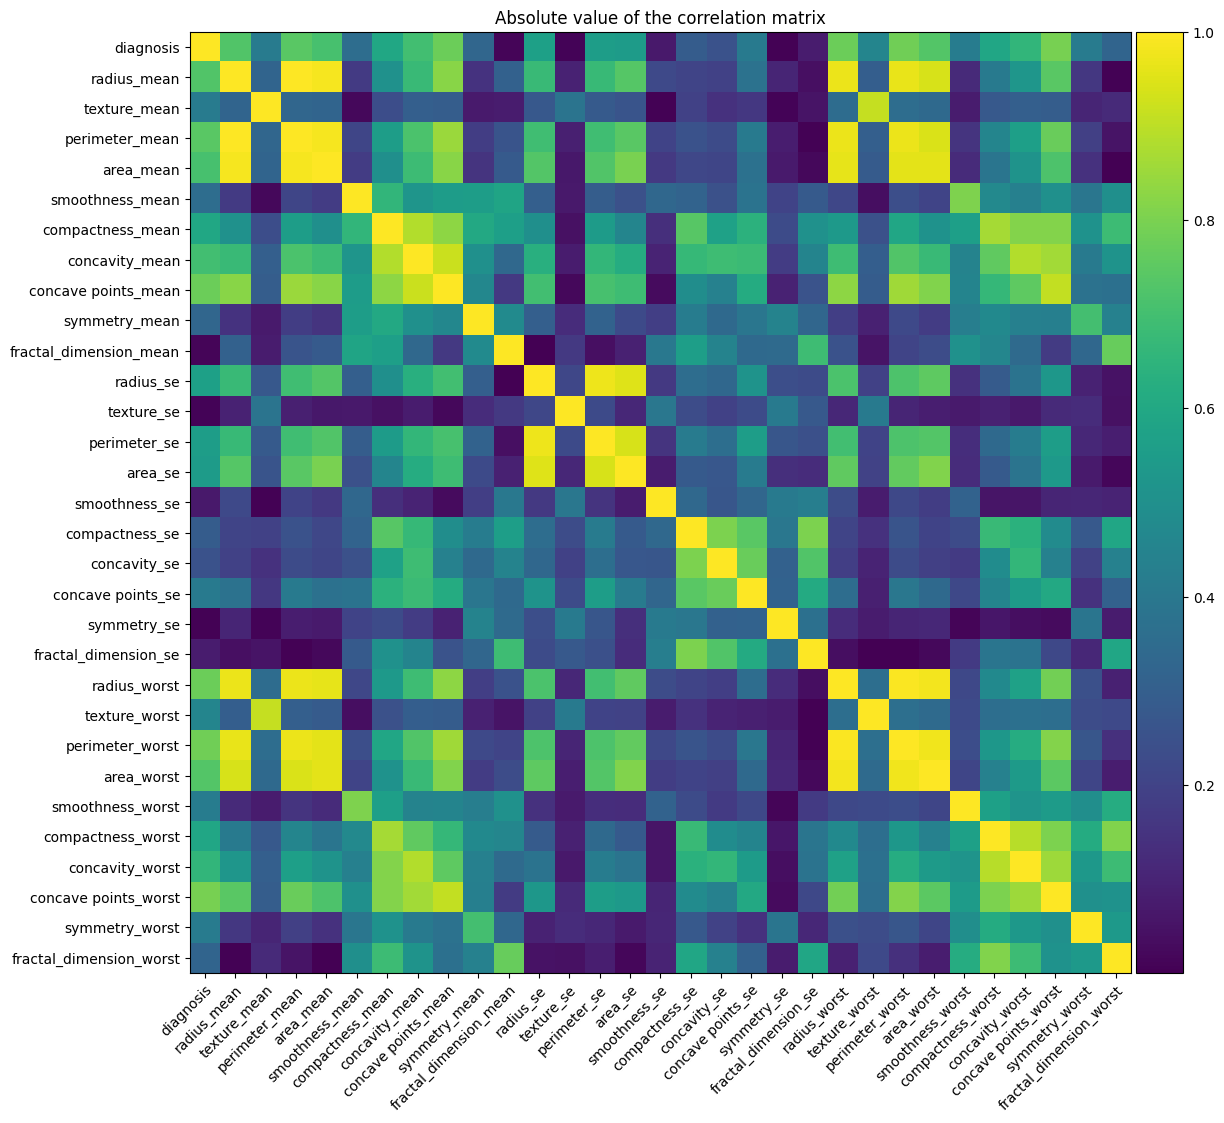

In [11]:
# A plot of the correlation matrix (using heatmap)
C = np.corrcoef(data.T)

fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(np.abs(C))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(ATTRIBUTES)), labels=ATTRIBUTES)
ax.set_yticks(np.arange(len(ATTRIBUTES)), labels=ATTRIBUTES)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Absolute value of the correlation matrix")
fig.tight_layout()
colorbar(im)
plt.show()


In [12]:
# split X and Class values
y = data['diagnosis']
X = data.drop(columns=['diagnosis'])

# split X into two subsets, one for diagnosis Malignant and one for diagnosis Benign
X_M = X.loc[data['diagnosis'] == 1, :]
X_B = X.loc[data['diagnosis'] == 0, :]

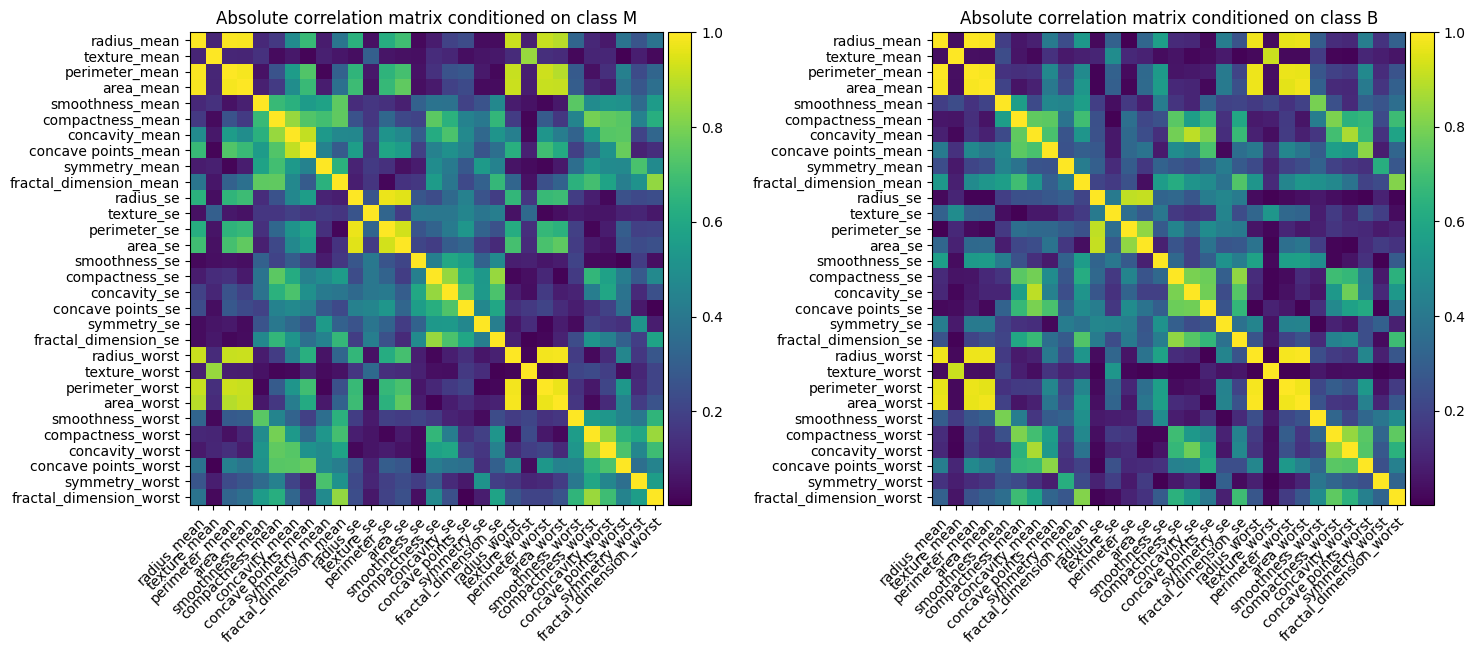

In [13]:
# A plot of the correlation matrices conditioned to class (using heatmap)

C_M = np.corrcoef(X_M.T)
C_B = np.corrcoef(X_B.T)

fig, ax = plt.subplots(1,2, figsize = (15,15))
im_M = ax[0].imshow(np.abs(C_M))
im_B = ax[1].imshow(np.abs(C_B))

# Show all ticks and label them with the respective list entries
ax[0].set_xticks(np.arange(len(FEATURES)), labels=FEATURES)
ax[0].set_yticks(np.arange(len(FEATURES)), labels=FEATURES)
colorbar(im_M)

ax[1].set_xticks(np.arange(len(FEATURES)), labels=FEATURES)
ax[1].set_yticks(np.arange(len(FEATURES)), labels=FEATURES)
colorbar(im_B)

plt.tight_layout(h_pad=1)

# Rotate the tick labels and set their alignment.
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax[0].set_title("Absolute correlation matrix conditioned on class M")
ax[1].set_title("Absolute correlation matrix conditioned on class B")
plt.show()

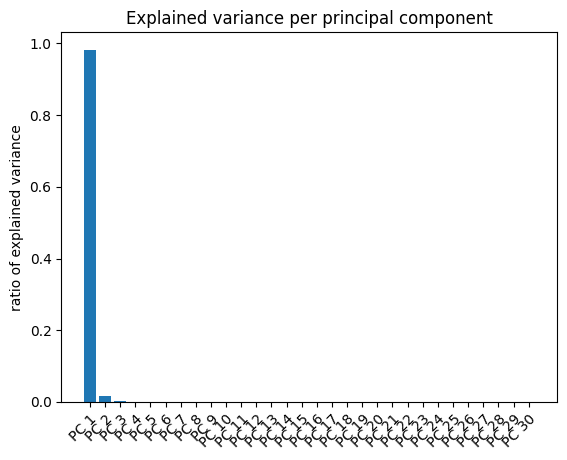

In [14]:
#some PCA
n_components = 30
pca = PCA(n_components = n_components)
pca.fit(X)

fig, ax = plt.subplots()
ax.bar(x = [f'PC {i+1}' for i in range(n_components)], height = pca.explained_variance_ratio_)
ax.set_ylabel('ratio of explained variance')
ax.set_title('Explained variance per principal component')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()



In [15]:
pca.explained_variance_ratio_

array([9.82044672e-01, 1.61764899e-02, 1.55751075e-03, 1.20931964e-04,
       8.82724536e-05, 6.64883951e-06, 4.01713682e-06, 8.22017197e-07,
       3.44135279e-07, 1.86018721e-07, 6.99473205e-08, 1.65908880e-08,
       6.99641650e-09, 4.78318306e-09, 2.93549214e-09, 1.41684927e-09,
       8.29577731e-10, 5.20405883e-10, 4.08463983e-10, 3.63313378e-10,
       1.72849737e-10, 1.27487508e-10, 7.72682973e-11, 6.28357718e-11,
       3.57302295e-11, 2.76396041e-11, 8.14452259e-12, 6.30211541e-12,
       4.43666945e-12, 1.55344680e-12])

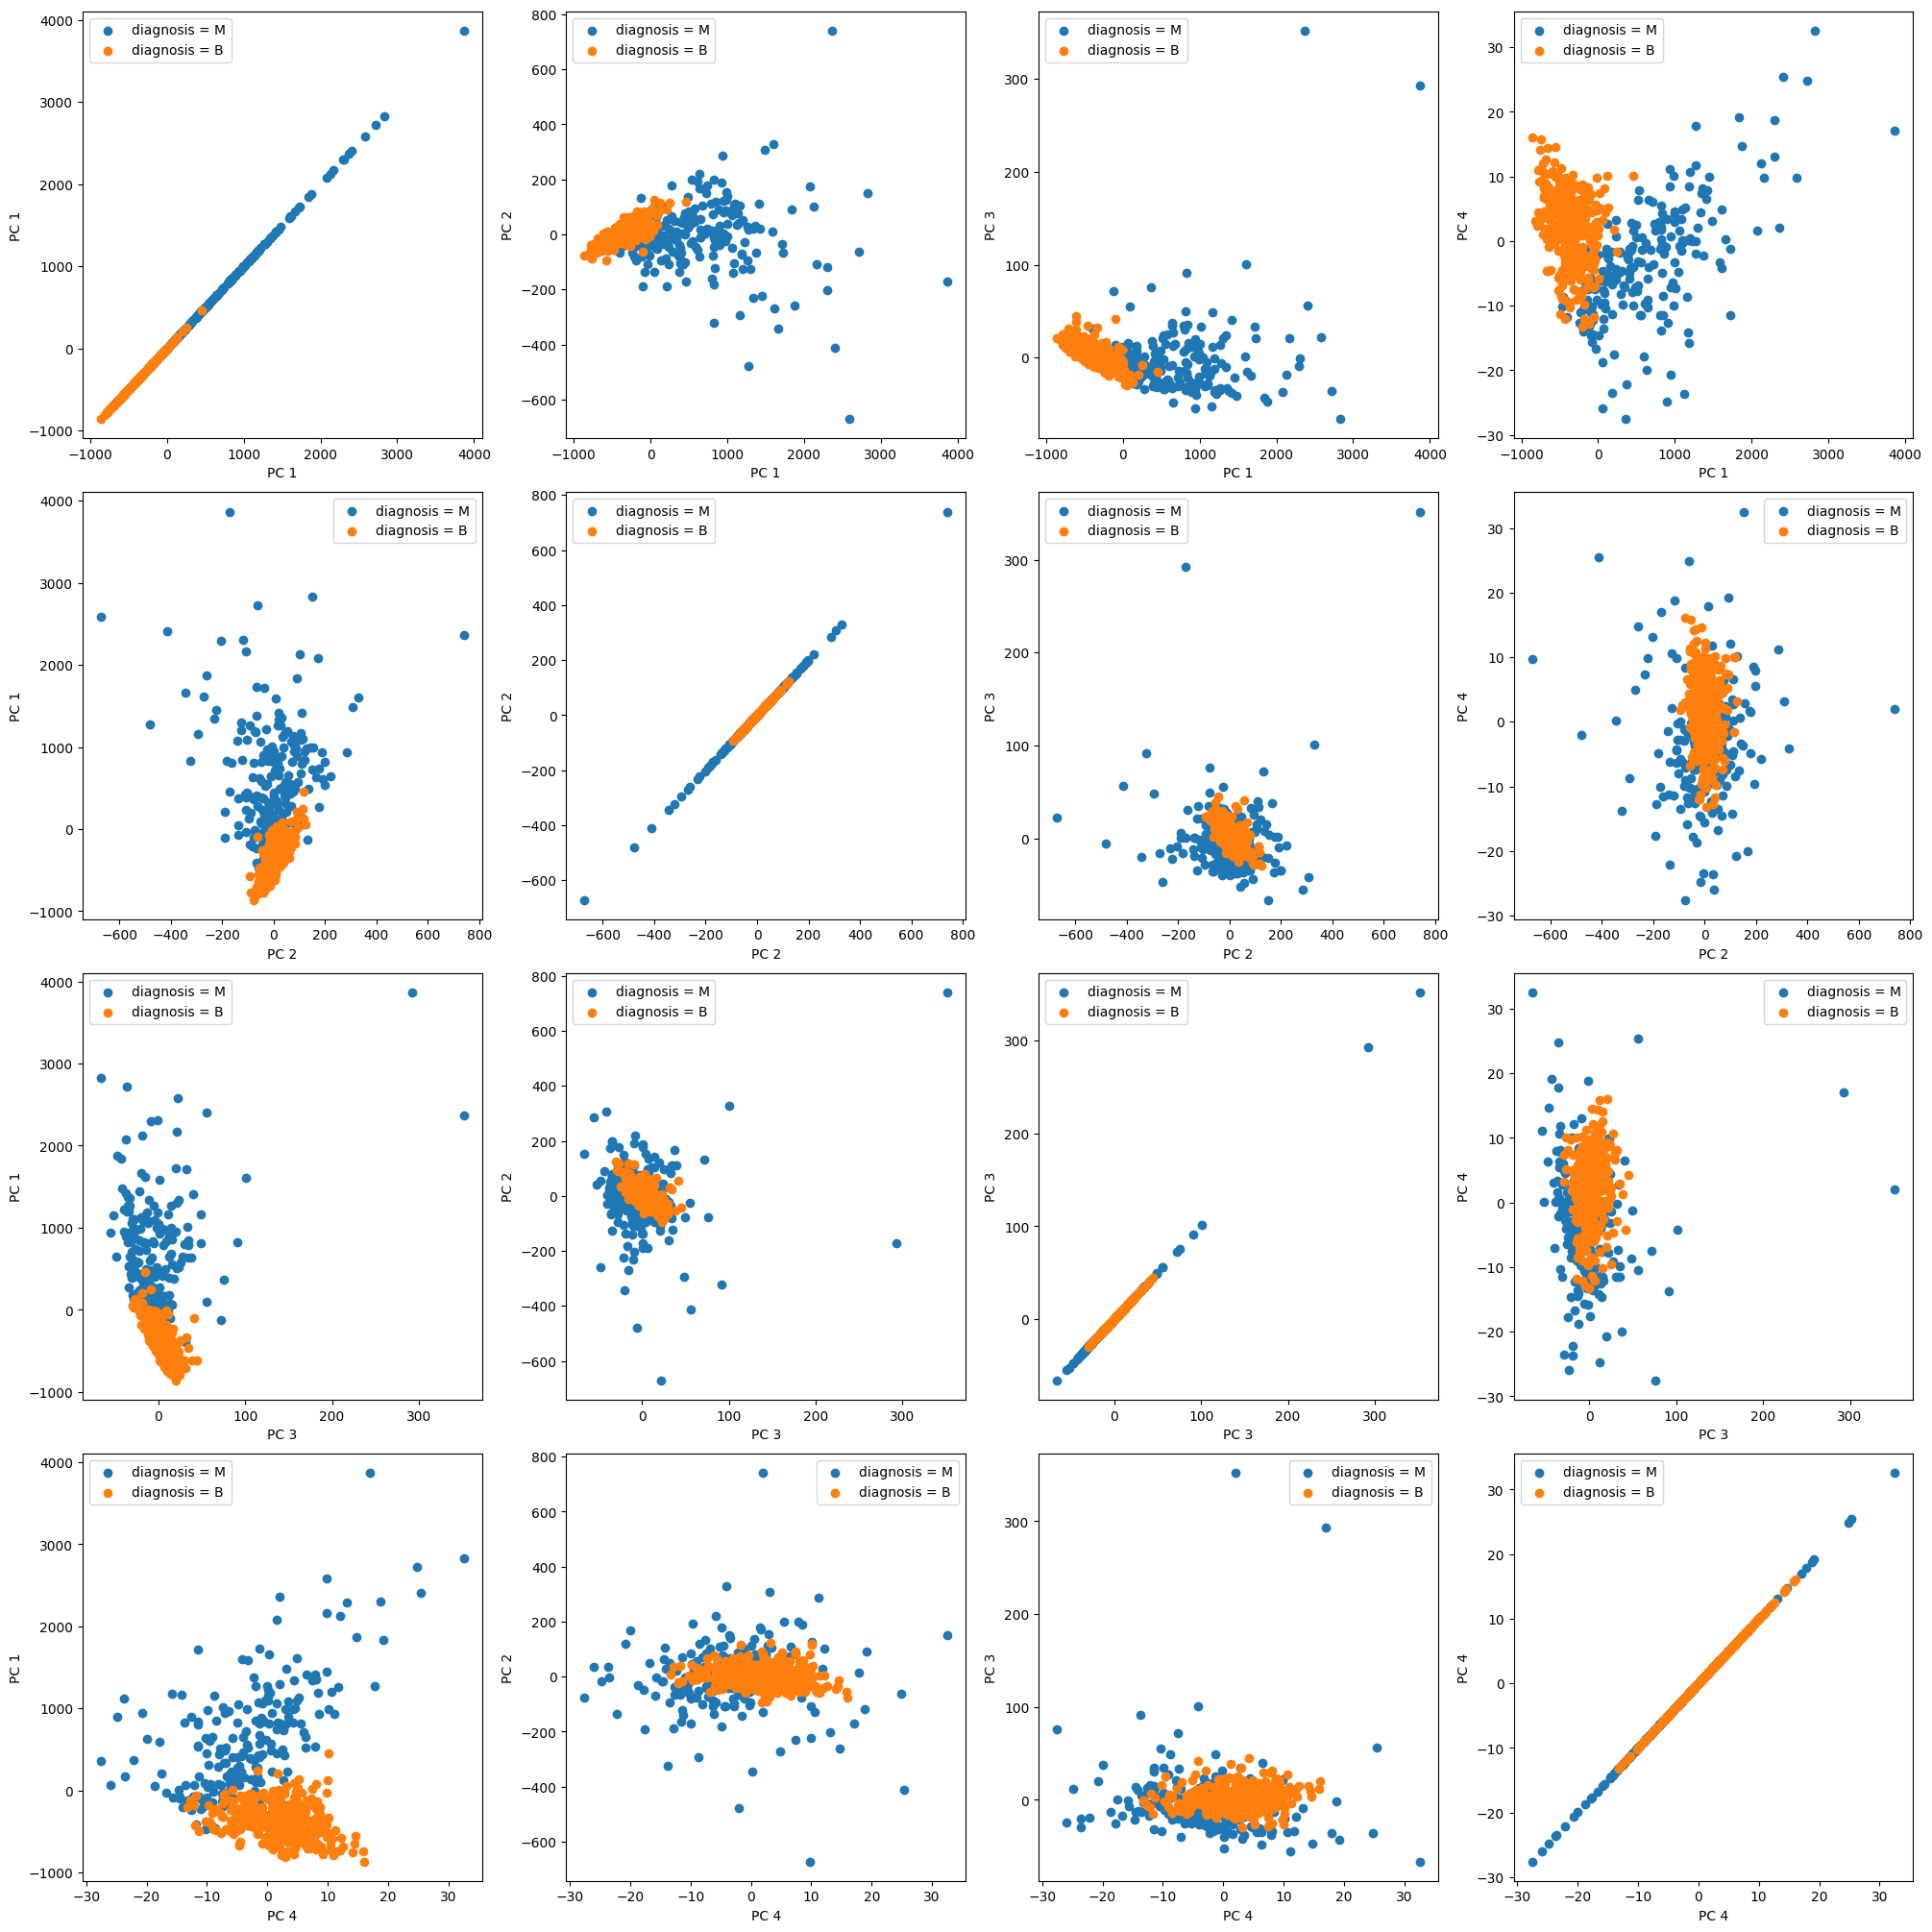

In [16]:
component_projections_M = pca.transform(X_M)
component_projections_B = pca.transform(X_B)

fig, ax = plt.subplots(4,4, layout='constrained')
fig.set_figheight(20)
fig.set_figwidth(20)
for i,j in product(range(4),range(4)):
    ax[i,j].set_xlabel(f'PC {i+1}')
    ax[i,j].set_ylabel(f'PC {j+1}')
    ax[i,j].scatter(component_projections_M[:,i], component_projections_M[:,j], label='diagnosis = M')
    ax[i,j].scatter(component_projections_B[:,i], component_projections_B[:,j], label='diagnosis = B')
    ax[i,j].legend()
plt.show()

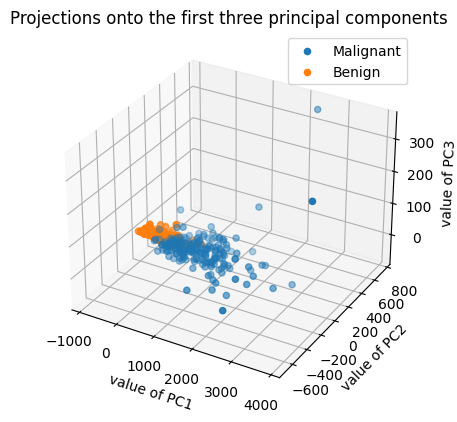

In [17]:
# A 3D plot of the first 3 PCs
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(component_projections_M[:,0], component_projections_M[:,1], component_projections_M[:,2],label="Malignant")
ax.scatter(component_projections_B[:,0], component_projections_B[:,1], component_projections_B[:,2],label="Benign")
ax.set_title('Projections onto the first three principal components')
ax.set_xlabel('value of PC1')
ax.set_ylabel('value of PC2')
ax.set_zlabel('value of PC3')
ax.legend()
plt.show()

## We can imagine that the point clouds are linearly separable once we add more dimensions. This is precisely the approach given in the original paper analysing the Wisconsin Breas Cancer dataset.

# Gaussian Naive Bayes

## Plot of the marginal distributions, showing that {feature}_mean and {feature}_worst may be approximated with a normal distribution, but {feature}_se is rather Chi-squared distributed.

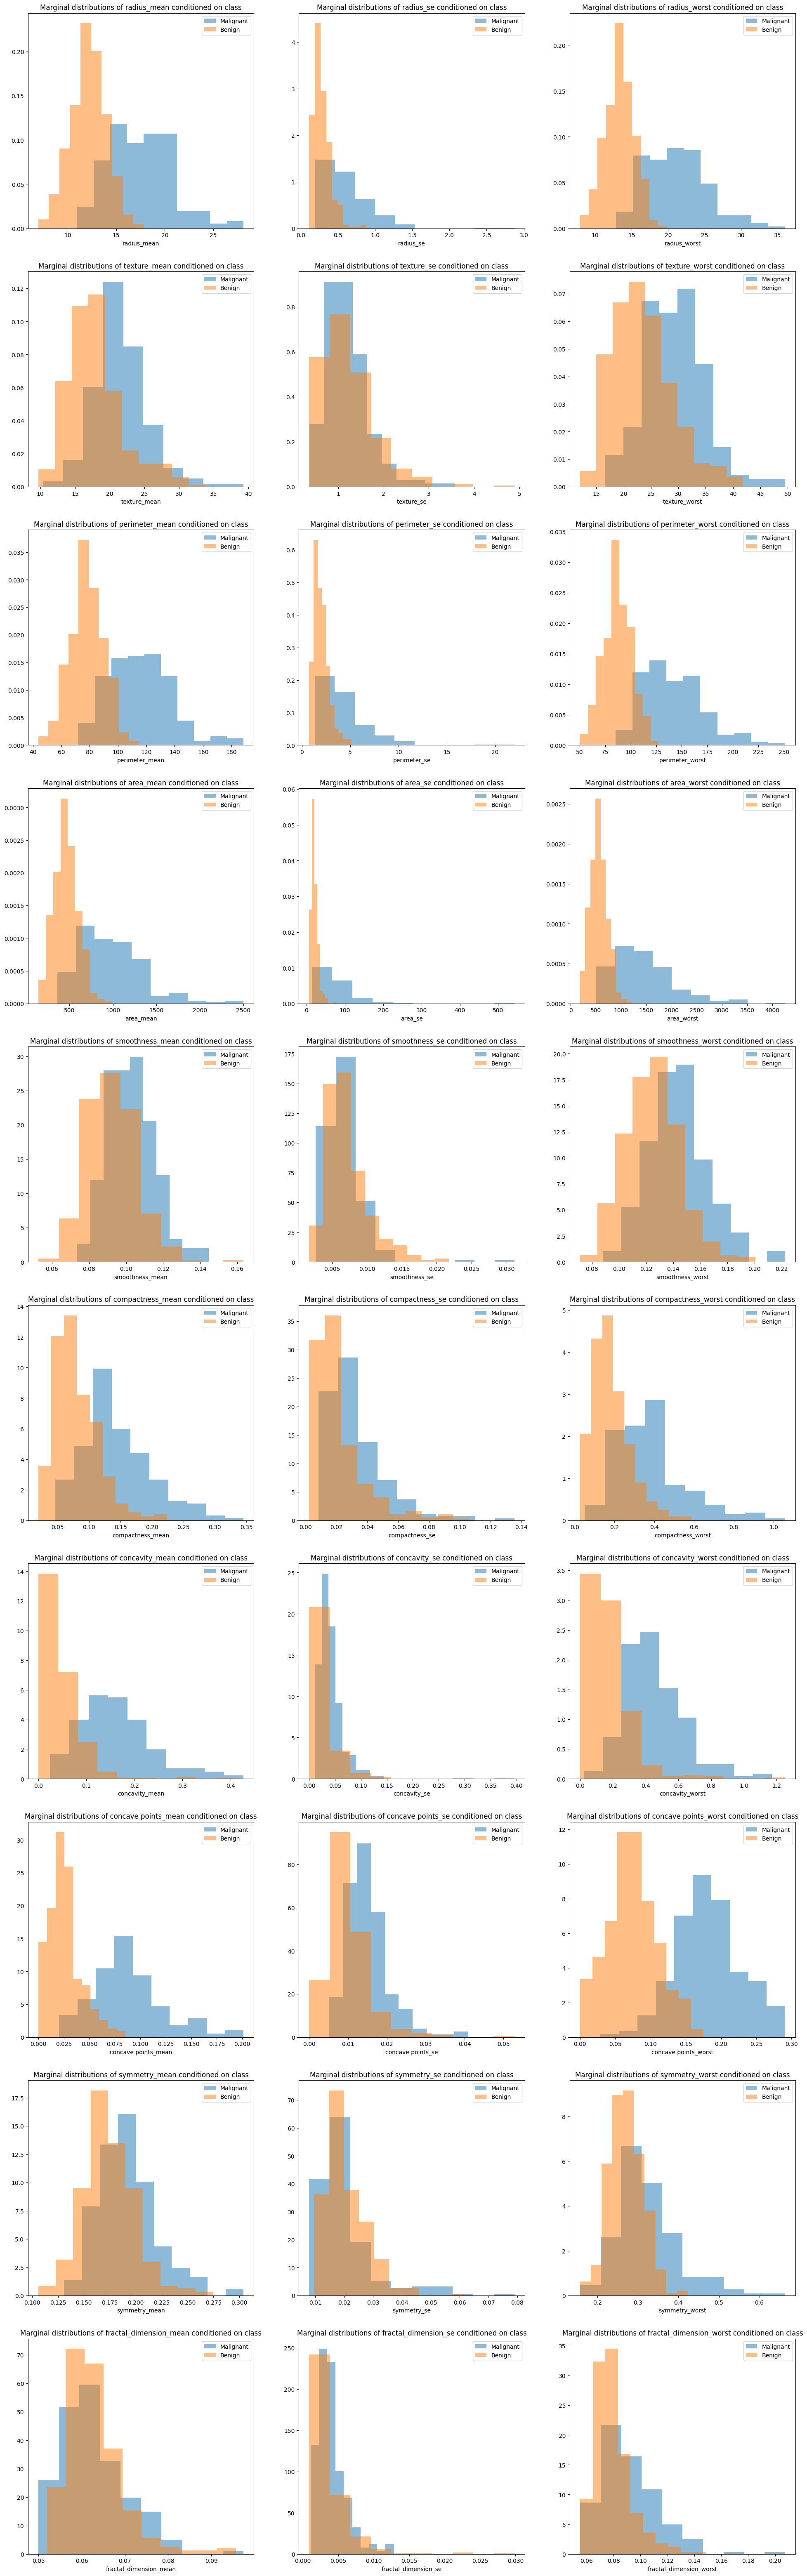

In [18]:
# What do the marginal distributions of each feature, conditioned to Malignant or Benign, look like?
fig, ax = plt.subplots(10,3, figsize=(8*3,8*10))
for i, basic_feature in enumerate([
    'radius',
    'texture',
    'perimeter',
    'area',
    'smoothness',
    'compactness',
    'concavity',
    'concave points',
    'symmetry',
    'fractal_dimension']):
    for j,statistic in enumerate(['mean','se','worst']):
        feature = f'{basic_feature}_{statistic}'
        ax[i,j].hist(X_M[feature], label='Malignant', density=True, alpha=.5)
        ax[i,j].hist(X_B[feature], label='Benign', density=True, alpha=.5)
        ax[i,j].set_title(f'Marginal distributions of {feature} conditioned on class')
        ax[i,j].set_xlabel(feature)
        ax[i,j].legend()
plt.show()


Based on the above marginal plots, together with the conditional correlation matrices, we make the following decisions:
- The assumption of features following a gaussian distribution when conditioned on class seems not to hold. Especially the _se variables are probably better modeled usign a chi-squared distribution.
- We will ignore that failure of our assumption for now.
- What we find more important, is that the model will use only features that have smalll correlations, because the Naive Bayes part of the GNBC assumptions should hold for our model to be somewhat justified.
- For this, we will use the method described in the report. It is adapted from the paper "Variable selection for Naïve Bayes classification" (R. Blanquero et al.)

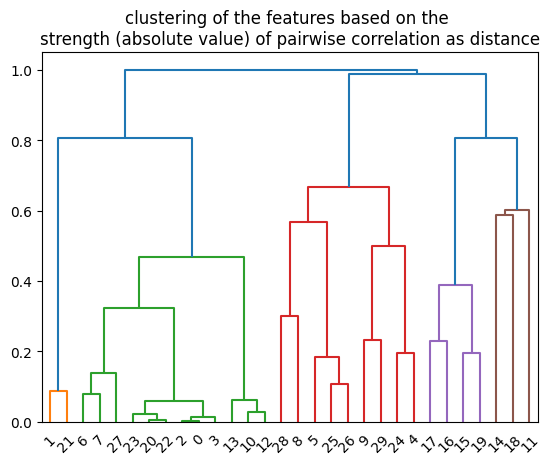

In [21]:
import scipy.cluster.hierarchy as hy

C_features = C[1:,1:]

# linkage from scipy.hierarchy uses either the dataset or a "condensed distance matrix", which means the 
# strict upper triangular part of a symmetric distance matrix. This can be extracted as follows:
# - use np.triu_indices_from, with the `from` matrix being C_features, and a column offset k=1.
condensed_dist_matrix = 1 - np.absolute(C_features[np.triu_indices_from(C_features, k=1)])

# Compute the linkage matrix Z (a complicated 4-by-n matrix representation of the hierarchical clustering).
linkage_matrix = hy.linkage(condensed_dist_matrix, method='complete', optimal_ordering=True)

# Plot the dendrogram to get some idea of the clustering of the features. 
# Unfortunately, hy.dendrogram was too complicated when trying to pass feature names. So the features are only shown as their
# column number (1, ... 30).
hy.dendrogram(linkage_matrix)
plt.title('clustering of the features based on the \nstrength (absolute value) of pairwise correlation as distance')
plt.show()

In [22]:
# We now flatten the hierarchy to n-clusters, where n=1, ... , 15
# We pick n=15 and not n=30 as our maximum cluster size because we don't believe such large feature sets hould be allowed.
# It will most certainly lead to overfitting. We already observed this for feature sets of size less than 15.
cl = dict()
for i in range(1,16):
    # First, flatten the cluster to i features:
    cl[i] = hy.fcluster(linkage_matrix, criterion='maxclust', t=i) - 1
    # cl[i] is now a list of indices [j_1, j_2, ... , j_30] , mapping each feature f to a cluster j_f.

    # This index list should be turned into a partition of the features. That is done by the following line:
    cl[i] = [[FEATURES[j] for j in filter(lambda n: cl[i][n] == k, range(30))] for k in range(i)]

In [23]:
# If you are curious to see these partitions, run this cell. It will provide you 15 n-partitions 
for i in range(1,16):
    print(cl[i])

[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']]
[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst'], ['smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'smoothn

In [24]:
# If we would look at all possible ways to pick one feature per partition block, how many total feature sets would that give for these 15 partitions?
# That we can compute with this cell. It is a large number, and we don't have time to iterate over all these feature sets. Even though it is much smaller than 
# 2^15 - 1, which was the number of feature subset that we would previously have to consider.
from math import prod
combination_count = sum([prod(list(map(len, cl[i]))) for i in range(1,16)])
combination_count

49880

In [25]:
# A function for making a heatmap plot of the absolute value of the correlation matrix (using heatmap)
def printHeatMap(X, feature_list):
    C = np.corrcoef(X[feature_list].T)
    fig, ax = plt.subplots()
    im = ax.imshow(np.abs(C))
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(feature_list)), labels=feature_list)
    ax.set_yticks(np.arange(len(feature_list)), labels=feature_list)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    ax.set_title(f"Correlation Matrix\n Feature subset: {feature_list}")
    fig.tight_layout()
    plt.colorbar(im)
    plt.show()

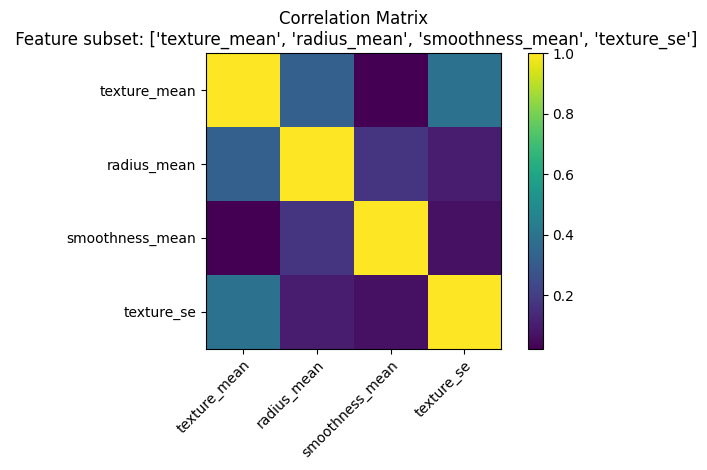

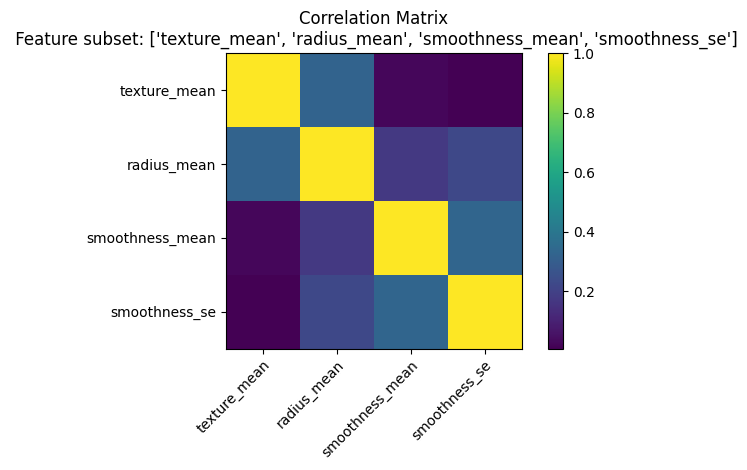

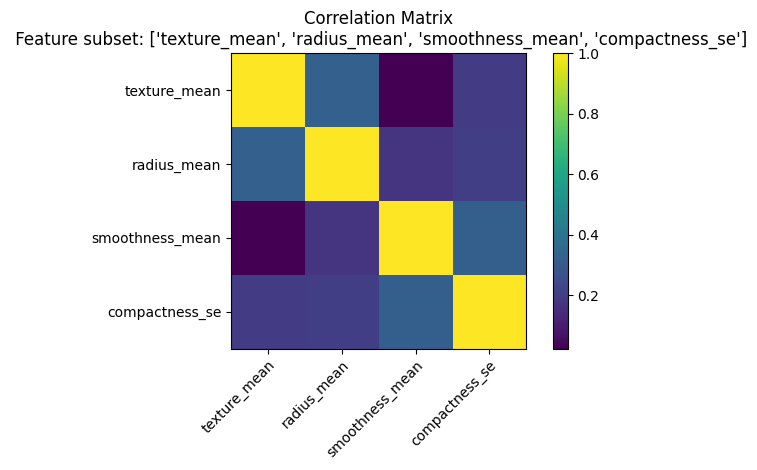

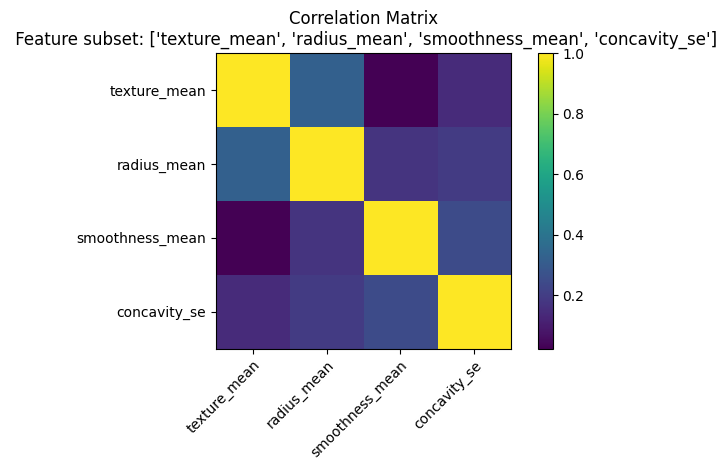

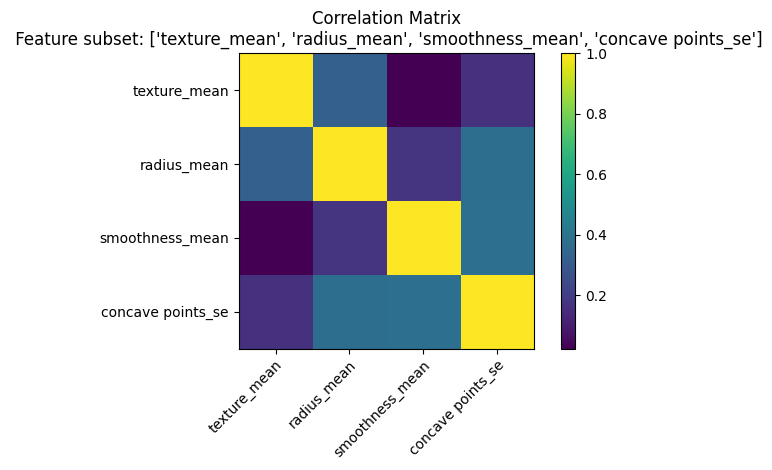

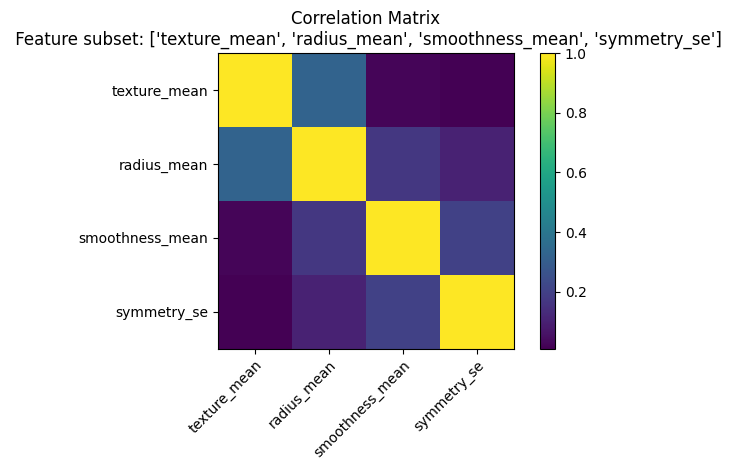

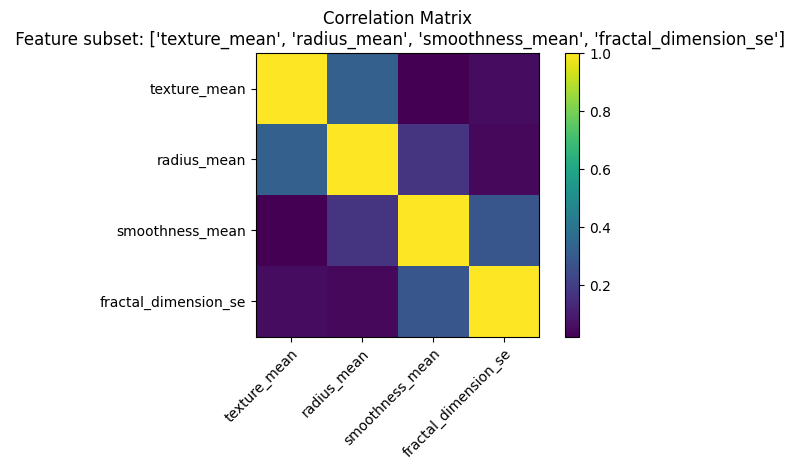

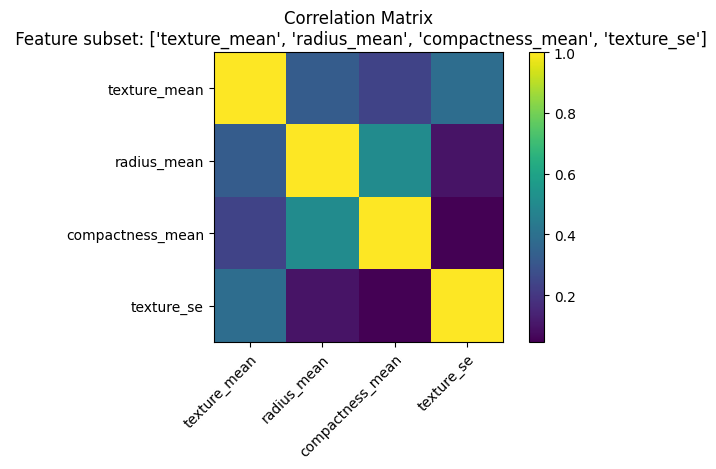

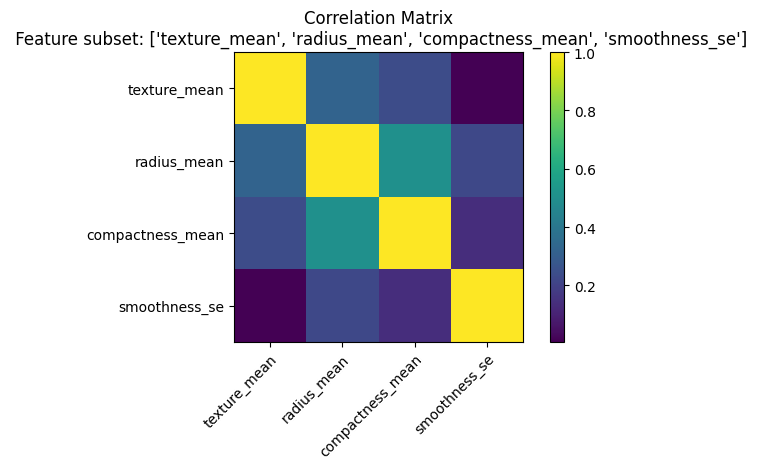

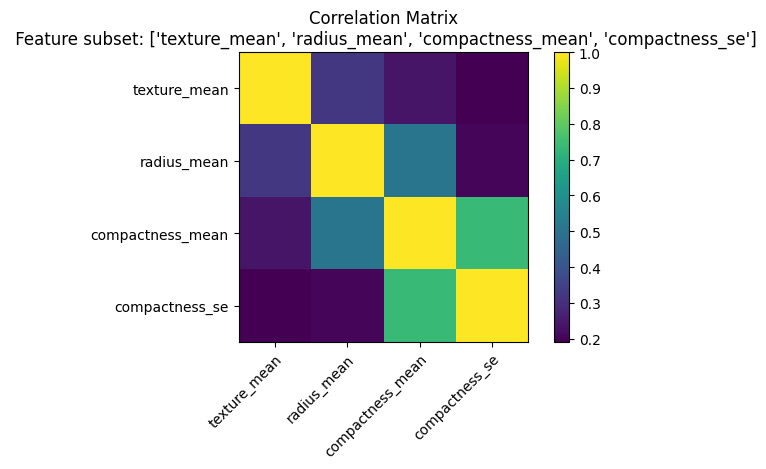

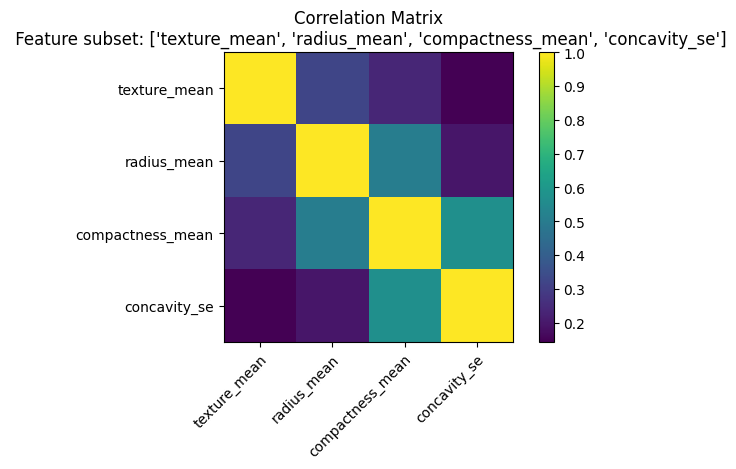

In [26]:
# To show you how it works:
for i,feature_list in enumerate(product(*cl[4])):
    if i > 10:
        break
    else:
        printHeatMap(X,list(feature_list))

In [27]:
# Since clustering leaves still too large a number of feature sets to consider, 
# we will just pick 10 candidate feature sets for each value of n. 
# To do this randomly, we need to shuffle, because itertools.product has a "slow stride" and a "fast stride" list, and we 
# don't want an unbalanced number of slow-stride features, we want enough variety!
import random
random.seed = 8

candidate_feature_sets = dict()
for n in range(1,16):
    shuffled_product = list(list(k) for k in product(*cl[n]))
    random.shuffle(shuffled_product) # this assures that we don't get very similar (i.e. overlapping) feature subsets for the same value of n
    candidate_feature_sets[n] = shuffled_product[:10]

In [28]:
# Here you can print the dictionary. It may clarify some things, but do note that this will throw 15000 feature lists into a cell, so it is not pretty and will likely mess up your kernel
# print(candidate_feature_sets)

In [29]:
# A custom transformer for selecting features as part of a pipeline (this will be useful when we are going to do a lot of fits and CVs!)


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

In [30]:
# We will use a FeatureSelector piped into a Gaussian Naive Bayes classifier:
# - We regard the selection of features from allowed_features[n] as part of the model fit,
#   although we select the feature subset based on generalizing ability over an inner cross-validation.
# - We regard n as the only hyperparameter. n is the number of features that the model uses, and per n we
#   allow the model to select any subset of n features that is listed in allowed_features. We do not allow
#   the model to select any n-subset of the 31 features because that is computationally too expensive.
#   rather, we pre-select up to 15 possible n-subsets of features based on the hierarchical clustering w.r.t. correlation
#   shown above. The hierarchical clustering already reduces the possible sets of features by a lot, and we select 20 random
#   subsets from each flat clustering product.
classifier = Pipeline([
            ('selector', FeatureSelector(['area_worst'])),
            ('GNBC', GaussianNB())
                         ])



# This gives a "nested cross-validation" situation, where we 
# - iterate over n = 1, ... 15, where
#   - iterate over k folds of an outer CV (stratified-k-fold), where
#     - iterate over k folds of an inner CV, to search for the best generalizing choice of feature selection.
#     - evaluate this choice of feature selection on the test holdout of the outer fold, using 
#       the ordinary mean accuracy (over the k outer folds) as scoring metric.
# - compare the mean accuracy of (n) for each n = 1, ..., 15

# Based on this, we determine which choice of hyperparameter 

# If we would have been more correct, the selection of the 20 allowed feature-sets should also be part of the model fit (since only
# then we truly bootstrap the result of the fit: now we base the selection of 20 allowed feature-sets on the full dataset rather than
# the inner fold). But this is again too computationally expensive to do: it means performing a clustering in every nested fold, 
# i.e. k^2 clusterings if we use two k-folds.

In [31]:
mean_scores = []
mean_fpr = np.linspace(0, 1, 100)

# dictionary to store the best classifiers (i.e. choice of n-feature set) for n in [1,15]
clf = dict() 

# The number of folds in the inner and outer StratifiedKFold
k = 7

train_scores = []
test_scores  = []

# The hyperparameter is n  (which can be chosen from 1, ... , 15)
for n in tqdm(range(1,16)):
    # The parameters are all possible combinations of feature subsets found from the hierarchical clustering:
    p_grid = {'selector__columns' : (candidate_feature_sets[n])} 
    outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)
    inner_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)
    clf[n] = GridSearchCV(estimator=classifier, param_grid=p_grid, cv=inner_cv)
    cross_validation = cross_validate(estimator=clf[n], cv=outer_cv, X=X, y=y, return_train_score=True)
    train_scores.append(cross_validation['train_score'].mean())
    test_scores.append(cross_validation['test_score'].mean())

100%|███████████████████████████████████████████| 15/15 [00:24<00:00,  1.66s/it]


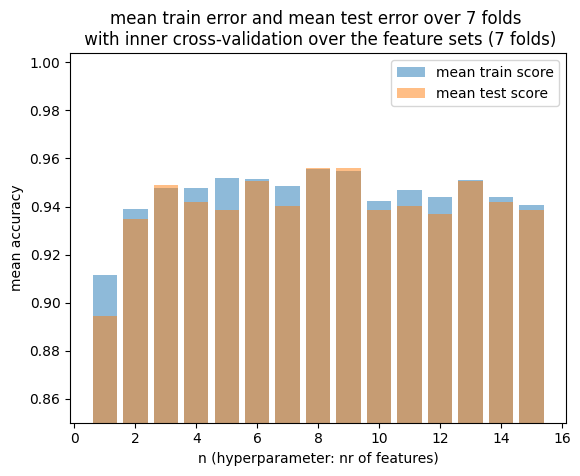

In [35]:
fig, ax = plt.subplots()

plt.bar(range(1,16), train_scores, label='mean train score', alpha=.5)
plt.bar(range(1,16), test_scores, label='mean test score',alpha=.5)
ax.set_ylim(0.85, ax.get_ylim()[1])
plt.legend()
plt.ylabel('mean accuracy')
plt.xlabel('n (hyperparameter: nr of features)')
plt.title(f"mean train error and mean test error over {k} folds \n with inner cross-validation over the feature sets ({k} folds)")
plt.show()

In [36]:
# Now, there is a problem with our application of the approach of Blanquero et al.:
# - The hierarchical clustering of correlated Blanquero assures that if a set of features is considered, all its subsets are as well.
# - I.e. if we have a feature set f1, f2, f3, f4, .. fn then fi comes from the i-th cluster, but then there is also a subclustering with n-1, n-2, ... features, and
#   these clusterings will give in the product of their partition blocks, any set f1, ... fi-1, fi+1, ... fn, so every subset in the end.
# - However, considering every subset of features of size n took too long for our computers. So we selected, for every n, randomly 10 candidate feature sets.
# - This also meant that the feature sets in candidate_feature_sets[n] do not have all their subsets also represented in the to be considered feature sets.
# - This is a mistake: it means that the train score will not increase monotonously with the number of included features, because the feature sets with rising n are not included within each other 
#   (i.e. there are holes in the ordering of feature sets w.r.t. the subset relation).
# - So our hyperparameter - train - test -error curve does not show much useful information (We even decided not to make it a curve, but to make it a barplot for this reason. There is no "graph" if we expect no clear
#   relationship between n and the train/test errors.

# - What we could have done is:
#  1. Use a strong computer that will iterate through all 49880 feature sets rather than just a pick of 150 sets. This will solve the problem and make the curve monotonous, 
#     so that we can see overfitting behaviour and make a bias-variance tradeoff decision.
#  2. Use a different kind of feature selection algorithm such as RFE (recursive feature elimination), where we recursively eliminate features from the set and thus assure that the feature sets that are compared
#     will always remain nested.

In [37]:
# For now, we will content ourselves with the choice of n that has the best mean test score: this is a classifier with n=5 (note that the feature set can be freely chosen from feature_sets[4], and this
# choice is considered part of the model fit.
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)
best_clf = GridSearchCV(estimator=classifier, 
                        param_grid={'selector__columns' : (candidate_feature_sets[5])}, 
                        cv=cv)
selected_columns = best_clf.fit(X,y).best_estimator_.get_params()['selector__columns']
selected_columns

['texture_worst',
 'perimeter_worst',
 'compactness_worst',
 'fractal_dimension_se',
 'symmetry_se']

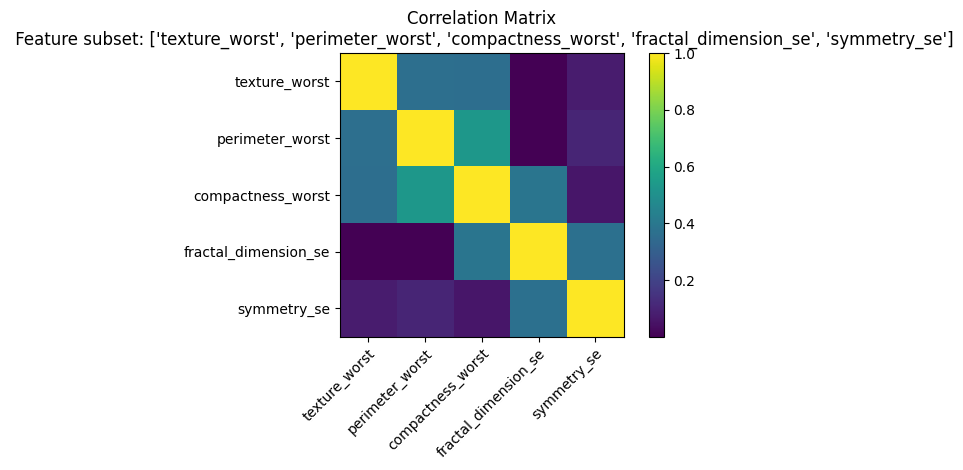

In [38]:
printHeatMap(X,selected_columns)